# 0. Import Packages and Load Data


In [3]:
# basic data frame
import pandas as pd
import numpy as np 

# balance check
import statsmodels.formula.api as smf



# visualization
import matplotlib.pyplot as plt

In [4]:
rg_df = pd.read_csv('RestaurantGrades Data.csv')

# 1. Randomization Control and Balance Check

Were the samples properly randomized? 

There are two characteristics of a restaurant: number of stars and type of restaurant (chain or not).

We need to check whether the characteristics of each were properly distributed before analyzing the a/b test results. 

Both statistical signifiance and economical significance are important for balance check. 

- Statistical significance measures whether the characteristics are statistically indistinguishable between groups
- Economical signifiance measures in terms of context (ex. is difference of 0.5 star ratings crucial?)



## 1a. Balance Check Hypothesis

**Stars_PreExperiment**

- H0: There is no difference of Stars_PreExperiment between two groups.

- H1: There is difference of Stars_PreExperiment between two groups.


**Chain**

- H0: There is no difference of Chain between two groups.

- H1: There is difference of Chain between two groups.

## 1b. Balance Check Methods
**Methods**

The methods to test whether they were balanced depends on the type of variable.

Stars_PreExperiment is a continuous variable and Chain is a categorical variable.

**Stars_PreExperiment**

- Method a: Two-sample t-tests for control vs treatment1 , treatment1 vs treatment 2
- Method b: Anova
- Method c: Linear Regression 

**Chain**
- Method a: Chi-squared Test
- Method b: Logistic Regression

We will use regression to conduct balance check, as it is applicable for both statistical and economical significance test. 

## 1c. Statistical Significance

### Stars_PreExperiment

In [5]:
# create treatment column 
rg_df['Treatment1'] = (rg_df['Treatment_Arm']==1).astype(int)
rg_df['Treatment2'] = (rg_df['Treatment_Arm']==2).astype(int)

# run linear regression model 
stars_stat_sig = smf.ols('Stars_PreExperiment~Treatment1+Treatment2', data = rg_df).fit()

# see summary
print(stars_stat_sig.summary())

                             OLS Regression Results                            
Dep. Variable:     Stars_PreExperiment   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                    0.7797
Date:                 Tue, 07 Oct 2025   Prob (F-statistic):              0.459
Time:                         22:10:16   Log-Likelihood:                -3619.5
No. Observations:                 3000   AIC:                             7245.
Df Residuals:                     2997   BIC:                             7263.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8635      0.026    151.01

Balance Check Pass: P values are both insignificant, meaning StarsPreExperiment variable is statistically indistinguishable. 

### Chain


In [6]:
# run logistic regression model 
chain_stat_sig = smf.logit('Chain~Treatment1+Treatment2', data = rg_df).fit()

# see summary
print(chain_stat_sig.summary())

Optimization terminated successfully.
         Current function value: 0.392487
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Chain   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2997
Method:                           MLE   Df Model:                            2
Date:                Tue, 07 Oct 2025   Pseudo R-squ.:               0.0004782
Time:                        22:10:16   Log-Likelihood:                -1177.5
converged:                       True   LL-Null:                       -1178.0
Covariance Type:            nonrobust   LLR p-value:                    0.5693
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9368      0.095    -20.325      0.000      -2.124      -1.750
Treatment1     0.1380      0.

Balance Check Pass:
P values are both insignificant, meaning Chain variable is statistically indistinguishable. 

## 1d. Economical Significance

To get a sense of economic significance, we examine correlations between characteristics and outcome. 

To do so, we use a regression with control group (since we don't have prior outcome data). 

The coefficients indicate how much gap in outcomes an imbalance in characteristics brings.

In [7]:
# take control group data
control_df = rg_df[rg_df['Treatment_Arm']==0]

economic_sig_stars = smf.ols('Reservations ~ Stars_PreExperiment + Chain', data=control_df).fit()

print(economic_sig_stars.params)

print(economic_sig_stars.summary())

Intercept             -22.639596
Stars_PreExperiment    13.637148
Chain                  -7.329562
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           Reservations   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     717.6
Date:                Tue, 07 Oct 2025   Prob (F-statistic):          8.35e-194
Time:                        22:10:17   Log-Likelihood:                -3671.0
No. Observations:                1000   AIC:                             7348.
Df Residuals:                     997   BIC:                             7363.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------

### Stars_PreExperiment
Balance Pass:

One increase of stars_pre_experiment increase reservations by 13.6371. 

Previously, we ran regression to estimate effect of treatment groups on this variable, and got coefficient of -0.045. 

This means the treatment 1 group has 0.045 less stars than the control group.

When we multiply 0.045 by 13.6371, we get 0.6, meaning that meaning that treatment1 group has 0.6 less of reservations than the control group.

0.6 reservations is not economically significant, meaning that the groups are well balanced. 



### Chain


While the chain variable itself is categorical, a question we really want to answer is:

How much does the proportion of chain restaurants differ between treatment and control groups? 

In a logistic regression, coefficients are in log-odds, not probabilities. Coefficient of treatment1 = 0.138 does not mean a 0.138 higher proportion of chain restaurants. To convert it to a probability difference, we'll need to compute marginal effects. 

By contrast, an OLS with a 0/1 dependent variable directly gives the difference in proportions.

Since we already have logistic regression output, we will use the params to convert.


In [8]:
chain_stat_sig.get_margeff(at='mean').summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  Chain
Method:                          dydx
At:                              mean
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Treatment1     0.0159      0.015      1.051      0.293      -0.014       0.046
Treatment2     0.0062      0.015      0.400      0.689      -0.024       0.036
==============================================================================
"""


Balance Pass:

When a restaurant is a chain, the number of reservations decrease by 7.3296.

The marginal effect calculates the change in probability of being a chain across groups. 

The marginal effect gives 0.0159 for treatment 1, meaning 1.5% higher probability of being a chain. 

Multiply 7.329 by 0.0159 gives almost 0, so the chain characteristics are well distributed across the experimental groups. 


# 2. Primary Metric Experiment Result

NSM = Reservations

Reservtions is the number of bookings made directly through RG platform in a month.

This metric is chosen because it is simple, business-aligned, scalable, and sensitive to experiments.

This metric is analogous to other two sided digital marketplaces: rides booked (Uber) or nights booked (Airbnb).

## 2a. ATE without Control Variable

Now we look at the experiment results to answer our causal question.

**Primary Causal Question**

If RG switches from the current layout to the new layout, will reservations increase?

Null Hypothesis (H₀)
- The average reservations per month in treatment1 and treatment2 groups are equal

Alternative Hypothesis (H₁)
- Average reservations per month are different in treatment2 and in treatment 1

Method A: Linear Regression

Method B: Two-sample t-test

**Secondary Causal Question**
Does the current ad lift conversions vs without ads?

Null Hypothesis (H₀)
- The average reservations per month in treatment1 and control groups are equal

Alternative Hypothesis (H₁)
- Average reservations per month are higher in treatment1 than in control


In [11]:
experiment_result = smf.ols('Reservations ~ Treatment1+Treatment2', data = rg_df).fit()
experiment_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Reservations   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     58.84
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           8.57e-26
Time:                        22:10:17   Log-Likelihood:                -12448.
No. Observations:                3000   AIC:                         2.490e+04
Df Residuals:                    2997   BIC:                         2.492e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.1240      0.485     60.016      0.000      28.173      30.075
Treatment1    -0.0430      0.686     -0.063      0.950      -1.389       1.303
Treatment2     6.4260      0.686      9.364      0.000       5.080       7.772
==============================================================================
Omnibus:                       55.826   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.173
Skew:                          -0.064   Prob(JB):                     1.03e-07
Kurtosis:                       2.509   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
control_res_coef = experiment_result.params[0]
treatment1_res_coef = experiment_result.params[0] + experiment_result.params[1]
treatment2_res_coef = experiment_result.params[0] + experiment_result.params[2]
arr = [control_res_coef,treatment1_res_coef,treatment2_res_coef]


/var/folders/pp/n1knqjg57ds10zbbb7v7yvfw0000gn/T/ipykernel_8707/2632074377.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  control_res_coef = experiment_result.params[0]
/var/folders/pp/n1knqjg57ds10zbbb7v7yvfw0000gn/T/ipykernel_8707/2632074377.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  treatment1_res_coef = experiment_result.params[0] + experiment_result.params[1]
/var/folders/pp/n1knqjg57ds10zbbb7v7yvfw0000gn/T/ipykernel_8707/2632074377.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Da

In [13]:
resy_lift = round((treatment1_res_coef - control_res_coef)*100/treatment1_res_coef,2)
resy_ads_lift = round((treatment2_res_coef - treatment1_res_coef)*100/treatment1_res_coef,2)
print(f"There is {resy_lift}% lift in reservations when restaurants post ads on our platform.")
print(f"There is {resy_ads_lift}% lift in reservations when restaurants use our alternative ad design instead of the current ad design.")

There is -0.15% lift in reservations when restaurants post ads on our platform.
There is 22.24% lift in reservations when restaurants use our alternative ad design instead of the current ad design.


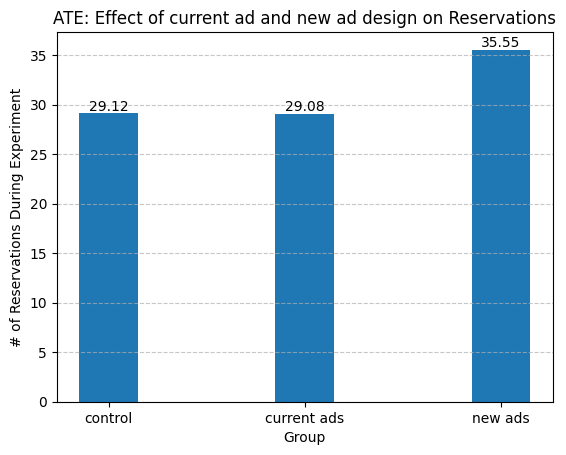

In [14]:
bars = plt.bar(['control','current ads', 'new ads'],[control_res_coef,treatment1_res_coef,treatment2_res_coef],width=0.3,align='center')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # x position (center of bar)
        height,                           # y position (top of bar)
        f'{height:.2f}',                  # format text
        ha='center', va='bottom', fontsize=10, color='black'
    )
plt.xlabel('Group')
plt.ylabel('# of Reservations During Experiment')
plt.title('ATE: Effect of current ad and new ad design on Reservations')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Primary Causal Question: Current Ads vs No Ads**

The p value of Treatment1 variable is greater than 0.05. We can't say being shown an ad versus no ad has any effect on number of reservations currently.

**Primary Causal Question: Current Ads vs New Ads**

The p values from linear regression tells us whether estimated coefficients of treatment1 and treatment2 are statistically different from 0. However, it doesn't test statistical significance from each other. We can conduct statistical test (t-test) to determine whether two coefficients are statistically different.

In [15]:
t_test = experiment_result.t_test('Treatment1 = Treatment2')
print(t_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -6.4690      0.686     -9.426      0.000      -7.815      -5.123


Another way to test is looking at SE: 

If Coefficient of treatment2 is within 2*SE (95% CI) of treatment1, they are not statistically different from each other. 

In [16]:
upper = experiment_result.params[1] + 2 * 0.686 
lower = experiment_result.params[1] - 2 * 0.686 
print(f"upper: {upper}, lower: {lower}")

upper: 1.3290000000001285, lower: -1.4149999999998717


/var/folders/pp/n1knqjg57ds10zbbb7v7yvfw0000gn/T/ipykernel_8707/728961200.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  upper = experiment_result.params[1] + 2 * 0.686
/var/folders/pp/n1knqjg57ds10zbbb7v7yvfw0000gn/T/ipykernel_8707/728961200.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower = experiment_result.params[1] - 2 * 0.686


In [17]:
print(experiment_result.params[2])

6.4260000000002275


/var/folders/pp/n1knqjg57ds10zbbb7v7yvfw0000gn/T/ipykernel_8707/1395300823.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(experiment_result.params[2])


**From t-test**

The p value of treatment2 is less than 0.05, meaning that the difference in coefficient between the two variables is statistically significant. We reject the null hypothesis and state that the average reservations per month are different in current ad design group and new ad design group.

**From regression**

The same occurs. The coefficient of alternative ad design group is not within the 95% CI of current ad design group; they are statistically different from each other. 

## 2b. ATE with Control Variables
In order to increase the precision of our estimates, we can add additional control variables to the regression. This is expected to reduce the residual (actual - predicted). 


In [18]:
experiment_result_control = smf.ols('Reservations ~ Treatment1+Treatment2+ Chain + Stars_PreExperiment', data = rg_df).fit()
experiment_result_control.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Reservations   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     1181.
Date:                Tue, 07 Oct 2025   Prob (F-statistic):               0.00
Time:                        22:10:17   Log-Likelihood:                -11085.
No. Observations:                3000   AIC:                         2.218e+04
Df Residuals:                    2995   BIC:                         2.221e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -23.9128      0.907    -26.378      0.000     -25.690     -22.135
Treatment1              0.7502      0.436      1.720      0.085      -0.105       1.605
Treatment2              6.7533      0.436     15.491      0.000       5.899       7.608
Chain                 -10.0450      0.524    -19.183      0.000     -11.072      -9.018
Stars_PreExperiment    14.0553      0.220     63.861      0.000      13.624      14.487
==============================================================================
Omnibus:                       59.348   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.830
Skew:                          -0.258   Prob(JB):                     3.42e-17
Kurtosis:                       3.583   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The standard errors of coefficients decreased, meaning precision of ATE got better. The expected value of ATE  for treatment2 increased by 0.3 and for treatment 1, it increased by 0.7.

The conclusion still wouldn't change when adding control coefficients.

Adding control variables decrease SE and therefore increase precision and power without changing the sample size.

Power is the probability of estimating the true ATE (chance of avoiding Type 2 FN error). We gain more power to detect whether the new ad layout truly increases reservations.

# 3. Secondary Metric Experiment Result 

Secondary Metrics are phone calls and page visits.

The number of phone calls from the restaurant’s page in a month.

The number of page visits to restaurant pages in a month.

These measure engagement and visibility, though reservations are the ultimate outcome.

## 3a. Phone Calls

In [20]:
experiment_result_2 = smf.ols('Calls ~ Treatment1+Treatment2', data = rg_df).fit()
experiment_result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Calls   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.384
Date:                Tue, 07 Oct 2025   Prob (F-statistic):             0.0126
Time:                        22:14:08   Log-Likelihood:                -13206.
No. Observations:                3000   AIC:                         2.642e+04
Df Residuals:                    2997   BIC:                         2.644e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.6080      0.625     37.784      0.000      22.383      24.833
Treatment1     2.3680      0.884      2.680      0.007       0.635       4.101
Treatment2     2.1480      0.884      2.431      0.015       0.415       3.881
==============================================================================
Omnibus:                      207.721   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              233.763
Skew:                           0.659   Prob(JB):                     1.73e-51
Kurtosis:                       2.633   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
control_res_coef = experiment_result_2.params[0]
treatment1_res_coef = experiment_result_2.params[0] + experiment_result_2.params[1]
treatment2_res_coef = experiment_result_2.params[0] + experiment_result_2.params[2]
arr_2 = [control_res_coef,treatment1_res_coef,treatment2_res_coef]


/var/folders/pp/n1knqjg57ds10zbbb7v7yvfw0000gn/T/ipykernel_8707/500347548.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  control_res_coef = experiment_result_2.params[0]
/var/folders/pp/n1knqjg57ds10zbbb7v7yvfw0000gn/T/ipykernel_8707/500347548.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  treatment1_res_coef = experiment_result_2.params[0] + experiment_result_2.params[1]
/var/folders/pp/n1knqjg57ds10zbbb7v7yvfw0000gn/T/ipykernel_8707/500347548.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with

In [28]:
phone_lift = round((treatment1_res_coef - control_res_coef)*100/treatment1_res_coef,2)
phone_ads_lift = round((treatment2_res_coef - treatment1_res_coef)*100/treatment1_res_coef,2)
print(f"There is {phone_lift}% lift in phone calls when restaurants post ads on our platform.")
print(f"There is {phone_ads_lift}% lift in phone calls when restaurants use our alternative ad design instead of the current ad design.")

There is 9.12% lift in phone calls when restaurants post ads on our platform.
There is -0.85% lift in phone calls when restaurants use our alternative ad design instead of the current ad design.


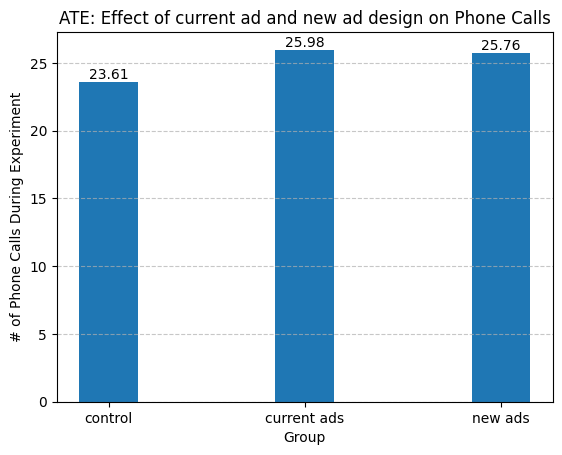

In [23]:
bars = plt.bar(['control','current ads', 'new ads'],[control_res_coef,treatment1_res_coef,treatment2_res_coef],width=0.3,align='center')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # x position (center of bar)
        height,                           # y position (top of bar)
        f'{height:.2f}',                  # format text
        ha='center', va='bottom', fontsize=10, color='black'
    )
plt.xlabel('Group')
plt.ylabel('# of Phone Calls During Experiment')
plt.title('ATE: Effect of current ad and new ad design on Phone Calls')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Primary Causal Question: Current Ads vs New Ads**

From the visualization, we don't see much change in new ads or current ads. 

**Secondary Causal Question: Current Ads vs No Ads**

We identified 9.12% lift in phone calls when restaurants post ads on our platform.

Is this statistically significant or due to random chance? 

The p value is less than 0.05 and is sufficient to reject null hypothesis. 

There is difference in phone call between control and current ads group, and when we look at the diagram above, we see increase in phone call by 2.

## 3b. Page Views

In [25]:
rg_df.columns

Index(['Restaurant_Number', 'Page_Views', 'Calls', 'Reservations',
       'Stars_PreExperiment', 'Chain', 'Treatment_Arm', 'Treatment1',
       'Treatment2'],
      dtype='object')

In [27]:
experiment_result_3 = smf.ols('Page_Views ~ Treatment1+Treatment2', data = rg_df).fit()
experiment_result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Page_Views   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     17.47
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           2.87e-08
Time:                        22:22:15   Log-Likelihood:                -19835.
No. Observations:                3000   AIC:                         3.968e+04
Df Residuals:                    2997   BIC:                         3.969e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    294.5960      5.694     51.735      0.000     283.431     305.761
Treatment1    47.5970      8.053      5.910      0.000      31.807      63.387
Treatment2    24.0860      8.053      2.991      0.003       8.296      39.876
==============================================================================
Omnibus:                       53.329   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.430
Skew:                           0.229   Prob(JB):                     2.25e-10
Kurtosis:                       2.619   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
control_res_coef = experiment_result_3.params[0]
treatment1_res_coef = experiment_result_3.params[0] + experiment_result_3.params[1]
treatment2_res_coef = experiment_result_3.params[0] + experiment_result_3.params[2]
arr_3 = [control_res_coef,treatment1_res_coef,treatment2_res_coef]


/var/folders/pp/n1knqjg57ds10zbbb7v7yvfw0000gn/T/ipykernel_8707/1206963128.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  control_res_coef = experiment_result_3.params[0]
/var/folders/pp/n1knqjg57ds10zbbb7v7yvfw0000gn/T/ipykernel_8707/1206963128.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  treatment1_res_coef = experiment_result_3.params[0] + experiment_result_3.params[1]
/var/folders/pp/n1knqjg57ds10zbbb7v7yvfw0000gn/T/ipykernel_8707/1206963128.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent w

In [30]:
page_lift = round((treatment1_res_coef - control_res_coef)*100/treatment1_res_coef,2)
page_ads_lift = round((treatment2_res_coef - treatment1_res_coef)*100/treatment1_res_coef,2)
print(f"There is {page_lift}% lift in page visits when restaurants post ads on our platform.")
print(f"There is {page_ads_lift}% lift in page visits when restaurants use our alternative ad design instead of the current ad design.")

There is 13.91% lift in page visits when restaurants post ads on our platform.
There is -6.87% lift in page visits when restaurants use our alternative ad design instead of the current ad design.


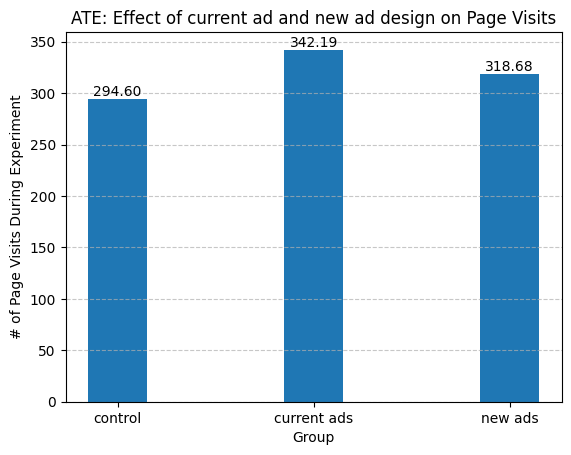

In [31]:
bars = plt.bar(['control','current ads', 'new ads'],[control_res_coef,treatment1_res_coef,treatment2_res_coef],width=0.3,align='center')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # x position (center of bar)
        height,                           # y position (top of bar)
        f'{height:.2f}',                  # format text
        ha='center', va='bottom', fontsize=10, color='black'
    )
plt.xlabel('Group')
plt.ylabel('# of Page Visits During Experiment')
plt.title('ATE: Effect of current ad and new ad design on Page Visits')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Primary Causal Question: Current Ads vs New Ads**

Current ads perform better in page views compared to new ads.

**Secondary Causal Question: Current Ads vs No Ads**

Current ad perform better in page views (13.91% lift) compared to no ads

In [32]:
t_test_3 = experiment_result_3.t_test('Treatment1 = Treatment2')
print(t_test_3)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            23.5110      8.053      2.920      0.004       7.721      39.301


In [34]:
t_test_3b = experiment_result_3.t_test('Treatment1 = Intercept')
print(t_test_3b)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0          -246.9990     12.733    -19.398      0.000    -271.965    -222.033


The p value is less than 0.05 meaning that the increase in page views for current ads is not due to random chance (in comparison to both new ads and no ads)

# 4. Conclusions

## 4a. Insights Summary

**Reservations**

The new ad design led to a statistically and economically significant increase in reservations, with an estimated lift of 6 additional reservations per restaurant per month—equivalent to a 22% improvement compared to the current ad design.
This result suggests that emphasizing dishes rather than restaurant profiles may drive stronger user intent and booking conversions.

**Phone Calls and Page Views**

For secondary engagement metrics:

Phone Calls: 

- Current ads outperformed both the new design and control group, resulting in an average increase of 2 calls per month (≈9% lift). The difference between the current and new designs was not statistically significant.

Page Views: 

- Current ads also increased visibility, generating 48 more page views (+13%) compared to no ads, whereas the new ad design led to a 24-view decline (–6.8%) relative to control.

These mixed results highlight a trade-off between visibility (page views, calls) and conversion (reservations).


## 4b. Strategic Implications

While reservations (North Star Metric) showed strong improvement, RG should carefully assess potential downstream impacts on upper-funnel engagement metrics before full deployment. A follow-up study could measure Heterogeneous Treatment Effects (HTE) across restaurant types (ex chain vs. independent, high vs. low star ratings) to understand which segments benefit most from the new design.



## 4c. External Validity and Scale-Up Considerations

Because the pilot sample included only non-subscribing restaurants, scaling results to paying advertisers may have limited external generalizability:

Price Sensitivity: 

- When RG adjusts ad pricing, current subscribers (often more price-sensitive) may respond differently, potentially reducing retention.

Implementation Constraints:

- Running a new A/B test among existing subscribers would require temporarily disabling ads for the control group, which could create business or client-relations challenges.

Analytical Adjustment: 

- For tests involving ongoing subscribers or longitudinal performance, a Difference-in-Differences (DiD) framework would help isolate incremental ad effects over time and account for pre-existing subscriber behavior.


## 4d. Final Recommendation

RG should proceed with a targeted roll-out:

Pilot the new ad layout among specific restaurant cohorts (ex. high-rated independents) identified through HTE analysis.

Monitor leading metrics (page views, calls) to ensure no unintended engagement drop.

Use DiD or longitudinal modeling when expanding to subscriber populations to validate external consistency.